In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("fivethirtyeight")

In [44]:
ipl=pd.read_csv('IPL_2023.csv')

ipl.head()

,POS,Player,Mat,Inns,NO,Runs,HS,Avg,BF,SR,100,50,4s,6s
0,1,Faf Du Plessis\nRCB,14,14,1,730,84,56.15,475,153.68,0,8,60,36
1,2,Shubman Gill\nGT,14,14,2,680,104*,56.67,446,152.46,2,4,67,22
2,3,Virat Kohli\nRCB,14,14,2,639,101*,53.25,457,139.82,2,6,65,16
3,4,Yashasvi Jaiswal\nRR,14,14,1,625,124,48.08,382,163.61,1,5,82,26
4,5,Devon Conway\nCSK,14,13,2,585,92*,53.18,422,138.62,0,6,69,16


In [45]:
ipl.shape

(163, 14)

In [46]:
ipl.columns

Index(['POS', 'Player', 'Mat', 'Inns', 'NO', 'Runs', 'HS', 'Avg', 'BF', 'SR',
       '100', '50', '4s', '6s'],
      dtype='object')

In [47]:
ipl.dtypes

POS         int64
Player     object
Mat         int64
Inns        int64
NO          int64
Runs        int64
HS         object
Avg        object
BF          int64
SR        float64
100         int64
50          int64
4s          int64
6s          int64
dtype: object

In [49]:

ipl = ipl.reset_index(drop=True)


In [51]:

ipl.replace('-', inplace=True)

ipl.dropna(inplace=True)

ipl.shape

/var/folders/3k/vnym605n7_v79xvzrn7vsb3m0000gn/T/ipykernel_39134/683036269.py:1: FutureWarning: DataFrame.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  ipl.replace('-', inplace=True)


(149, 14)

In [289]:
ipl.Player=ipl.Player.str.replace('\n', ' ')
ipl.HS=ipl.HS.str.replace('*','')

ipl.HS.astype(float)
ipl.Avg.astype(float)
print()

#### Cleaning the outliers for a better prediction

In [300]:
cols=['BF','Runs', 'HS','Avg','SR','100','6s','50','NO','4s','Inns','Mat']

ipl[cols] = ipl[cols].apply(pd.to_numeric, errors='coerce')

Q1 = ipl[cols].quantile(0.25)
Q3 = ipl[cols].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to remove outliers only in the specified columns
ipl = ipl[~((ipl[cols] < lower_bound) | (ipl[cols] > upper_bound)).any(axis=1)]

print("Shape before removing outliers:", ipl.shape)
print("Shape after removing outliers:", ipl.shape)


Shape before removing outliers: (110, 14)
Shape after removing outliers: (110, 14)


## Exploratory Data Analysis

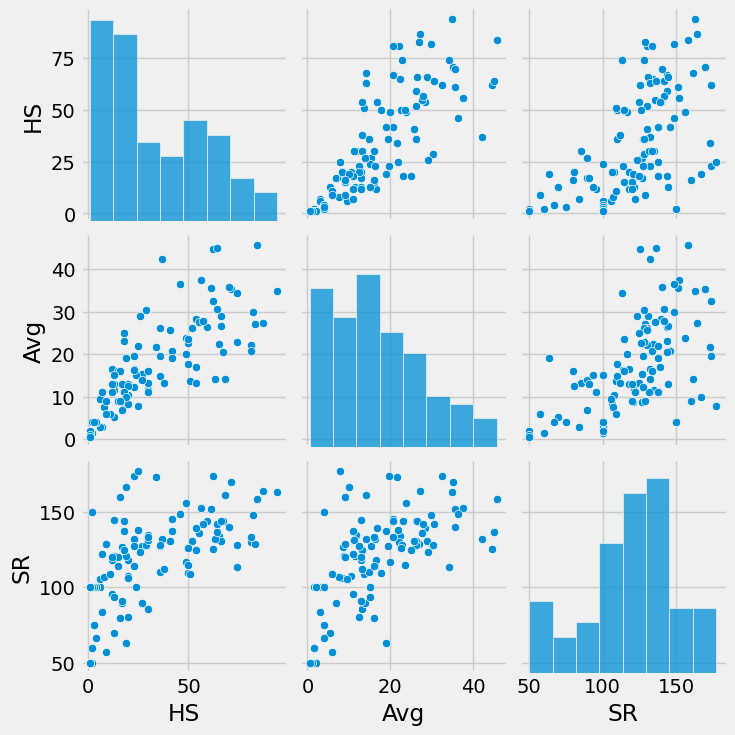

In [301]:
sns.pairplot(ipl, vars=['HS','Avg','SR'])
plt.show()

Highest score increases almost linearly as average of a batsman increases whereas mode of average of batsmen are low scorers (less than 20 average)

Increase in highest score is generally met with strike rates around and more than 150 and dispersed average of batsmen

Batsmen with strike rates more than 200 are very less and very few of them have a high average and highest scores (generally outliers)

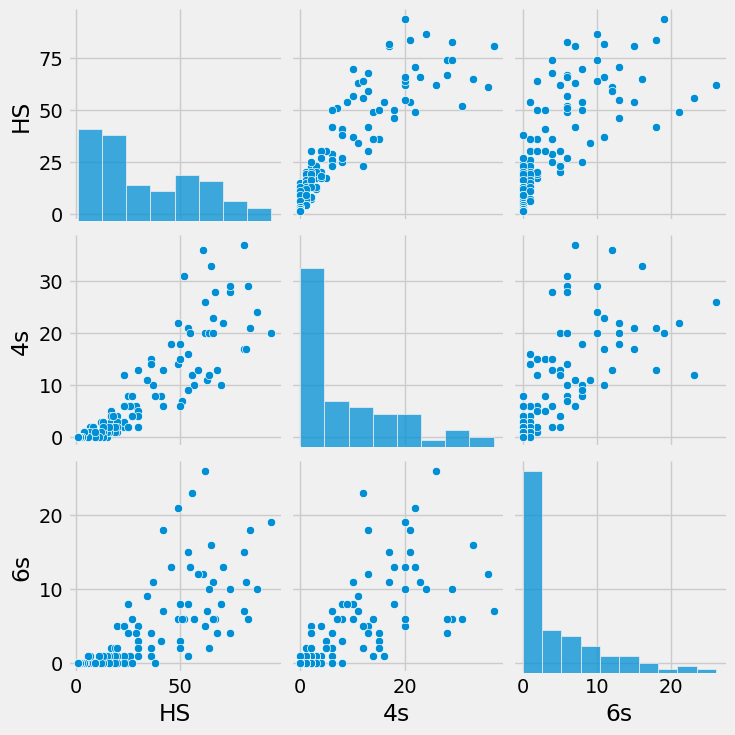

In [302]:
sns.pairplot(ipl, vars=['HS','4s','6s'])
plt.show()

Countably few batsmen are able to score more than 20 4s and 6s and amount of 4s and 6s rapidly reduce as highest score reaches its peak

Almost every batsmen has lower 6s than 4s and highest score increases more rapidly as 4s increase than 6s

This implies a batsmen is highest scoring due to contribution of his 4s than 6s as 4s outnumber 6s at elite level

The Highest score curve of 4s is steeper(linear regressor slope) than the Highest score curve of 6s which means again 4s matter more than 6s

## Feature selection using heatmap

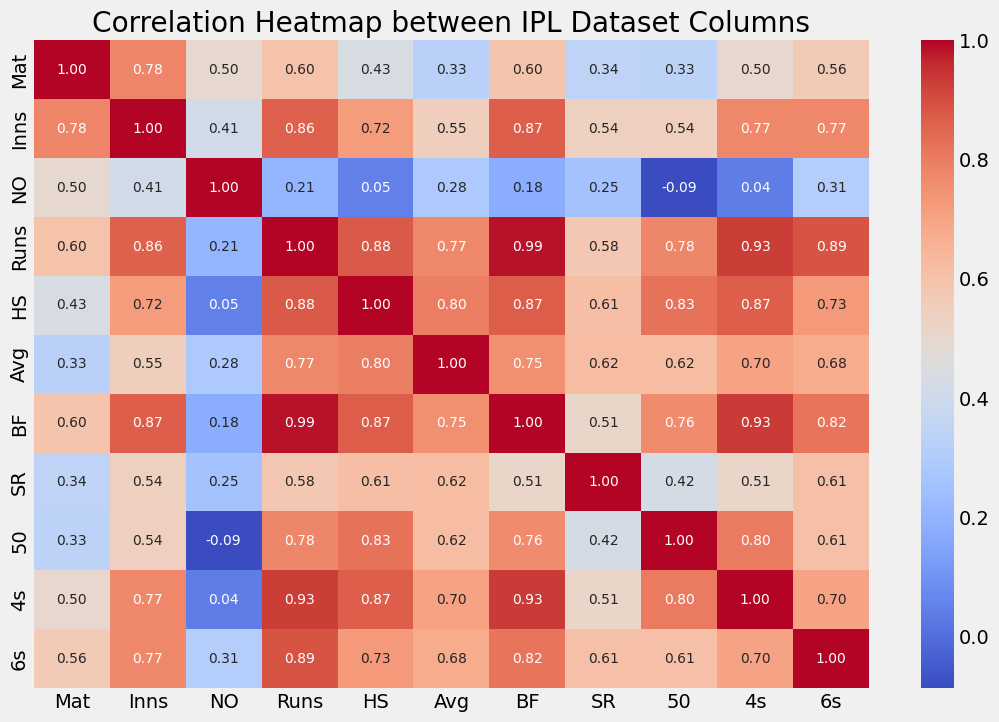

In [312]:

subset_df = ipl[['Mat', 'Inns', 'NO', 'Runs', 'HS', 'Avg', 'BF', 'SR', '50', '4s', '6s']]

corr_matrix = subset_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Heatmap between IPL Dataset Columns')
plt.show()

Most appropriate inputs seem to be BF, Runs, 50, HS, Inns, 6s, Avg by that order

These must be included in training and testing dataset for sure

# Training and Testing

#### Linear Regression 

In [313]:
X=ipl[['BF','Runs', 'HS','Avg','SR','6s']]

Y=ipl['4s']

In [314]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [315]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)

Y_train_pred = lr_model.predict(X_train)
Y_test_pred = lr_model.predict(X_test)

mse_train = mean_squared_error(Y_train, Y_train_pred)
mse_test = mean_squared_error(Y_test, Y_test_pred)

print("Mean Squared Error (Train):", mse_train)
print("Mean Squared Error (Test):", mse_test)


Mean Squared Error (Train): 4.729688541546594
Mean Squared Error (Test): 4.970901197835958


#### Polynomial Regression

In [317]:

poly_features= PolynomialFeatures(degree=2)
X_poly_train =poly_features.fit_transform(X_train)
X_poly_test =poly_features.transform(X_test)

poly_reg = LinearRegression()
poly_reg.fit(X_poly_train, Y_train)

poly_train_pred= poly_reg.predict(X_poly_train)
poly_test_pred = poly_reg.predict(X_poly_test)

mse_poly_train= mean_squared_error(Y_train, poly_train_pred)
mse_poly_test = mean_squared_error(Y_test, poly_test_pred)

print("Polynomial Regression MSE (Train):", mse_poly_train)
print("Polynomial Regression MSE (Test):",mse_poly_test)


dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_train, Y_train)

dt_train_pred =dt_reg.predict(X_train)
dt_test_pred =dt_reg.predict(X_test)

mse_dt_train= mean_squared_error(Y_train, dt_train_pred)
mse_dt_test =mean_squared_error(Y_test, dt_test_pred)

print("Decision Tree Regressor MSE (Train):", mse_dt_train)
print("Decision Tree Regressor MSE (Test):", mse_dt_test)


rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, Y_train)

rf_train_pred =rf_reg.predict(X_train)
rf_test_pred =rf_reg.predict(X_test)

mse_rf_train= mean_squared_error(Y_train, rf_train_pred)
mse_rf_test =mean_squared_error(Y_test, rf_test_pred)

print("Random Forest Regressor MSE (Train):", mse_rf_train)
print("Random Forest Regressor MSE (Test):", mse_rf_test)

Polynomial Regression MSE (Train): 3.8168588009497983
Polynomial Regression MSE (Test): 25.49638181079848
Decision Tree Regressor MSE (Train): 0.0
Decision Tree Regressor MSE (Test): 22.363636363636363
Random Forest Regressor MSE (Train): 2.107062337662338
Random Forest Regressor MSE (Test): 12.726130303030303
